In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [37]:
# Часть 1

In [38]:
# Загрузка данных
file_path = 'AB_NYC_2019.csv'
data = pd.read_csv(file_path)

In [39]:
# Удаление ненужных признаков
data_cleaned = data.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'])

In [40]:
# Обработка пропусков
data_dropped = data_cleaned.dropna()
data_filled_mean = data_cleaned.fillna(data_cleaned.mean(numeric_only=True))
data_filled_median = data_cleaned.fillna(data_cleaned.median(numeric_only=True))
data_preprocessed = data_filled_median

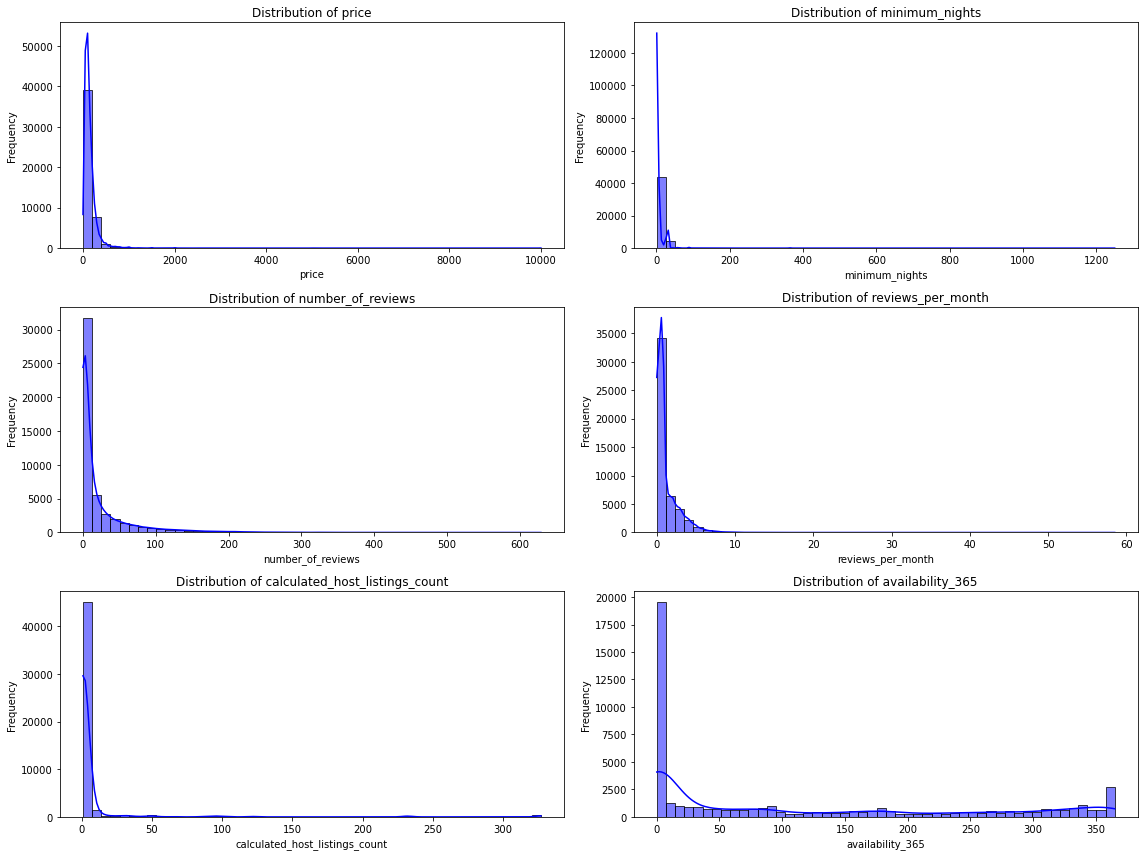

In [41]:
# Визуализация распределений
quantitative_cols = ['price', 'minimum_nights', 'number_of_reviews', 
                     'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(quantitative_cols):
    sns.histplot(data_preprocessed[col], bins=50, kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

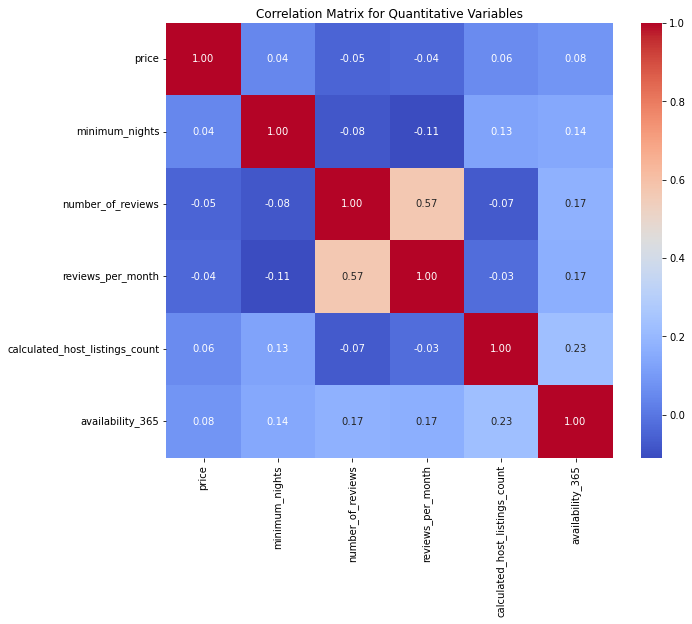

In [42]:
# Матрица корреляций
correlation_matrix = data_preprocessed[quantitative_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix for Quantitative Variables")
plt.show()

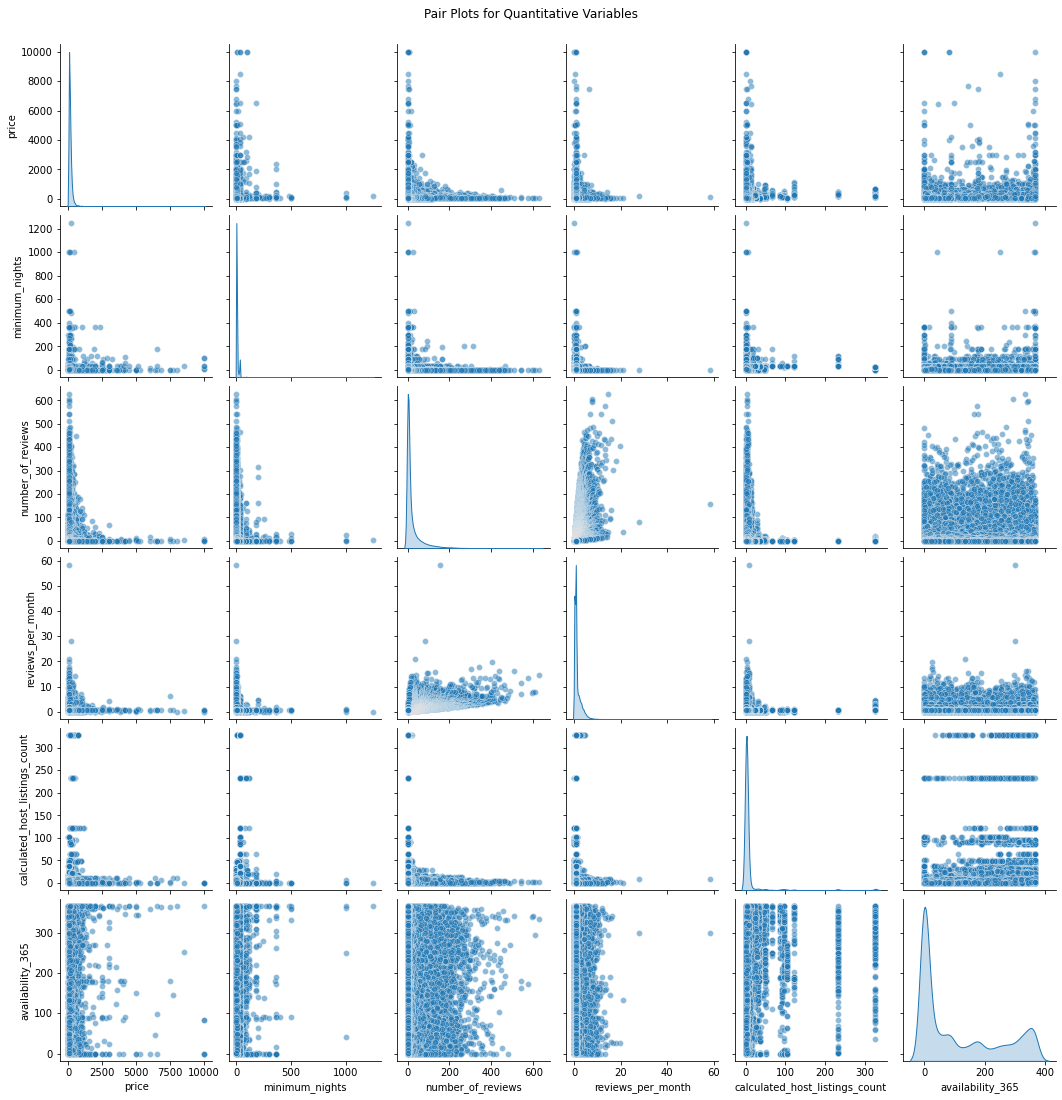

In [43]:
# Построение pair plots
sns.pairplot(data_preprocessed[quantitative_cols], diag_kind="kde", plot_kws={"alpha": 0.5}, height=2.5)
plt.suptitle("Pair Plots for Quantitative Variables", y=1.02)
plt.show()

In [44]:
# Часть 2

In [59]:
# Удаление аномалий в price
Q1 = data_cleaned['price'].quantile(0.25)
Q3 = data_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1
data_cleaned = data_cleaned[(data_cleaned['price'] >= (Q1 - 1.5 * IQR)) & 
                            (data_cleaned['price'] <= (Q3 + 1.5 * IQR))]

In [60]:
# Логарифмическое преобразование price
data_cleaned['log_price'] = np.log1p(data_cleaned['price'])

In [61]:
# Создание нового признака: расстояние до центра Манхэттена
def calculate_distance(lat, lon, center_lat=40.7831, center_lon=-73.9712):
    return np.sqrt((lat - center_lat)**2 + (lon - center_lon)**2)

data_cleaned['distance_to_manhattan'] = calculate_distance(data_cleaned['latitude'], data_cleaned['longitude'])

In [62]:
# One-hot encoding для категориальных признаков
data_cleaned['reviews_per_month'] = data_cleaned['reviews_per_month'].fillna(0)
data_cleaned = data_cleaned.dropna()
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']
numerical_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 
                      'calculated_host_listings_count', 'availability_365', 'distance_to_manhattan']

In [63]:
# Разделение данных на признаки и целевую переменную
X = pd.get_dummies(data_cleaned[categorical_features + numerical_features], drop_first=True)
y = data_cleaned['log_price']

In [64]:
# One-hot encoding для категориальных переменных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(drop=None, handle_unknown='ignore'), categorical_features)
    ])

In [65]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Создание и обучение модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_estimators=100))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'distance_to_manhattan']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['neighbourhood_group',
                                                   'neighbourhood',
                                                   'room_type'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [53]:
# Оценка качества модели
y_pred = pipeline.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R2 Score: 0.6220
MAE: 0.2662
RMSE: 0.3507


Выводы:
1. Было применено удаление выбросов методом IQR в переменной price, так как это сильно искажает распределение, что улучшило поведение модели, так как экстремальные значения перестали искажать прогноз с соответствующим улучшением метрик (R2, MAE, RMSE)
2. Поскольку распределение price было сильно скошено вправо, мы применили логарифмическое преобразование, так как это обычно помогает моделям линейной и деревоподобной структуры, в связи с тем что целевая переменная становится более симметричной для снижение MAE и RMSE
3. Был добавлен новый признак, который заменяет необработанные latitude и longitude, используя расстояние до центра Манхэттена, так как обычно расстояние от центра города коррелирует с ценой (price), ожидается рост R2.
4. Преобразование neighbourhood_group, neighbourhood, и room_type в числовую форму с использованием one-hot encoding улучшило работу модели с категориальными переменными
5. Был протестирован RobustScaler, чтобы минимизировать влияние выбросов, и другие шкалирования

In [66]:
# Модели
models = {
    'Linear Regression': LinearRegression(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5),
    'LassoCV': LassoCV(alphas=np.logspace(-6, 6, 13), cv=5),
    'ElasticNetCV': ElasticNetCV(alphas=np.logspace(-6, 6, 13), l1_ratio=[0.1, 0.5, 0.9], cv=5)
}

In [67]:
# Результаты
results = pd.DataFrame(columns=['Model', 'R2', 'MAE', 'RMSE'])
feature_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'R2': [r2], 'MAE': [mae], 'RMSE': [rmse]})], ignore_index=True)
    if hasattr(model, 'coef_'):
        feature_importances[name] = pd.Series(model.coef_, index=X.columns)

/Users/edwardblack-kholodov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 937.1281242399327, tolerance: 0.9561554146369817
  model = cd_fast.enet_coordinate_descent_gram(
/Users/edwardblack-kholodov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1426.5871020352251, tolerance: 0.943218144163442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/edwardblack-kholodov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1100.6309405215154, tolerance: 0.9475389815454935
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ed

/Users/edwardblack-kholodov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1438.2655749853784, tolerance: 0.943218144163442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/edwardblack-kholodov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1113.6859408327082, tolerance: 0.9475389815454935
  model = cd_fast.enet_coordinate_descent_gram(
/Users/edwardblack-kholodov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1301.8109395093518, tolerance: 0.9515167845486809
  model = cd_fast.enet_coordinate_descent_gram(
/Users/e

               Model                   R2          MAE           RMSE
0  Linear Regression -245006122295.583679  2922.443366  278879.337012
1            RidgeCV             0.578727     0.277709       0.365687
2            LassoCV             0.579272     0.277593       0.365451
3       ElasticNetCV             0.579254     0.277595       0.365458


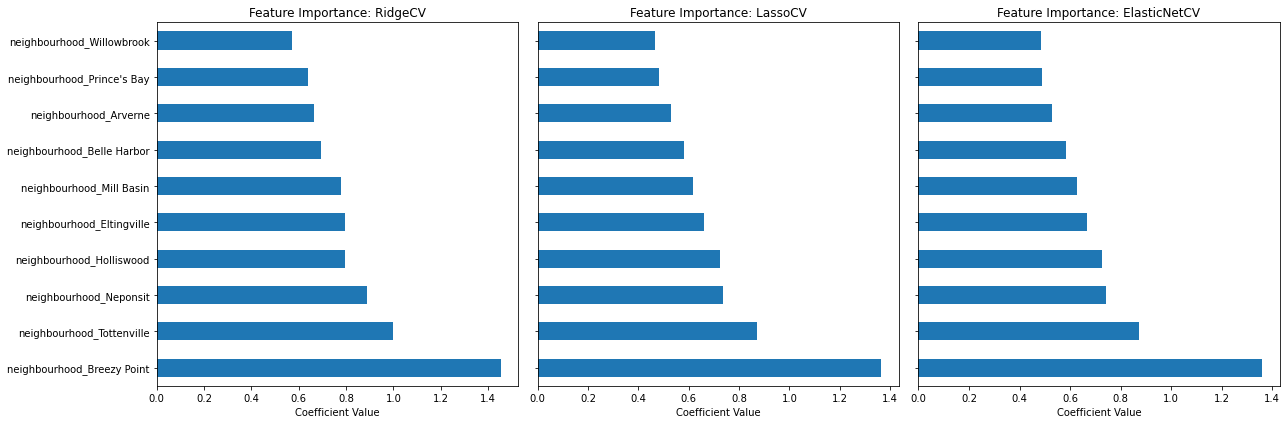

In [68]:
# Вывод результатов
print(results)

# Визуализация важности признаков для регуляризованных моделей
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax, model_name in zip(axes, ['RidgeCV', 'LassoCV', 'ElasticNetCV']):
    if model_name in feature_importances:
        feature_importances[model_name].sort_values(ascending=False).head(10).plot(kind='barh', ax=ax)
        ax.set_title(f'Feature Importance: {model_name}')
        ax.set_xlabel('Coefficient Value')

plt.tight_layout()
plt.show()